# 実践用プログラム

## ライブラリをインポートする

In [1]:
from keras.models import Sequential
from keras.utils import np_utils, plot_model
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.initializers import glorot_uniform, orthogonal, TruncatedNormal
from keras.callbacks import EarlyStopping
from keras.layers.recurrent import GRU, SimpleRNN

import pandas as pd #行列計算
import numpy as np #行列計算
import math #数値計算
import itertools #順列・組み合わせ

import matplotlib.pyplot as plt #グラフ
from datetime import datetime, timedelta
import mpl_finance as mpf
import talib as ta # テクニカル指標

from df_method import rise_fall_rate, moving_average, GCDC, df_shift, add_data, RSI, Z_score_normalization, Min_Max_normalization

Using TensorFlow backend.


## ニューラルネットワーク構築

In [2]:
class Prediction :
    #初期化
    def __init__(self, maxlen, n_hidden, n_in, n_out, learning_model):
        self.maxlen = maxlen #入力系列数
        self.n_hidden = n_hidden #出力次元（隠れ層内のニューロン数）
        self.n_in = n_in #学習データの列数
        self.n_out = n_out #ラベルデータの列数
        
        self.learning_model = learning_model #●学習モデルの選択

    #モデルの生成
    def create_model(self):
        model = Sequential()
        if self.learning_model == 'RNN':
            #RNN層
            model.add(SimpleRNN(self.n_hidden,
                                batch_input_shape = (None, self.maxlen, self.n_in),
                                kernel_initializer = glorot_uniform(seed=20170719),
                                recurrent_initializer = orthogonal(gain=1.0, seed=20170719),
                                dropout = 0.5,
                                recurrent_dropout = 0.5))
        elif self.learning_model == 'LSTM':
            #LSTM層
            model.add(LSTM(self.n_hidden,
                           batch_input_shape = (None, self.maxlen, self.n_in),
                           kernel_initializer = glorot_uniform(seed=20170719), 
                           recurrent_initializer = orthogonal(gain=1.0, seed=20170719), 
                           dropout = 0.5, 
                           recurrent_dropout = 0.5))
        elif self.learning_model == 'GRU':
            #GRU層
            model.add(GRU(self.n_hidden,
                          batch_input_shape = (None, self.maxlen, self.n_in),
                          kernel_initializer = glorot_uniform(seed=20170719),
                          recurrent_initializer = orthogonal(gain=1.0, seed=20170719),
                          dropout = 0.5,
                          recurrent_dropout = 0.5))
        #ドロップアウト層
        model.add(Dropout(0.5))
        #結合層
        model.add(Dense(self.n_out, kernel_initializer = glorot_uniform(seed=20170719)))
        #活性化層
        model.add(Activation("softmax"))
        #コンパイル
        model.compile(loss="categorical_crossentropy", optimizer = "Adam", metrics = ['categorical_accuracy']) # "RMSprop"
        return model

    # 学習
    def train(self, x_train, t_train, batch_size, epochs) :
        early_stopping = EarlyStopping(patience=0, verbose=1)
        model = self.create_model()
        self.hist = model.fit(x_train, t_train, batch_size = batch_size, epochs = epochs, verbose = 1,
                              shuffle = True, callbacks = [early_stopping], validation_split = 0.1)
        return model

# 変数を宣言

In [4]:
is_debug = True #デバッグモード
csv_path = './csv/' # 使用するcsvの存在するフォルダのパス
x_days_later = 1 #何日先の増減を調べるか？
learning_model = 'GRU' # 使用するネットワーク（RNN, LSTM, GRU）
start_date = '2009-3-10'# 起点年月日
end_date = '2018-10-31'# 終点年月日
maxlen = 300 # 入力系列数（過去何日分のデータを用いるか）
n_hidden = 200     # 隠れ層のユニット数

# 学習データの用意

In [8]:
df_list = [] #データフレームのリスト

#　ドル円の始値と終値の差
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col='Date', parse_dates=True)#読み込み
df = df.apply(np.log)*100
df = df['USD_JPY_Close'] - df['USD_JPY_Open']#終値と始値の差を求める
df = df['1989-10-16':]#始値と終値と高値と安値が記録され始めた日からのみ抽出
df = df.rename('USD_JPY_diff')#名前を付ける
df = pd.DataFrame(df)# sriesからdataframeに変換
df_list.append(df)

# 使用する為替レート
df_list.append(add_data(csv_path+'USD_JPY.csv', x_days_later))
#df_list.append(add_data(csv_path+'EUR_JPY.csv', x_days_later))
#df_list.append(add_data(csv_path+'EUR_USD.csv', x_days_later))

#df_list.append(add_data(csv_path+'nikkei.csv', x_days_later))
#df_list.append(add_data(csv_path+'TOPIX.csv', x_days_later))
#df_list.append(add_data(csv_path+'DOW30.csv', x_days_later))
#df_list.append(add_data(csv_path+'NASDAQ.csv', x_days_later))

# 米国債
df = pd.read_csv(csv_path+'treasury_10.csv', index_col='Date', parse_dates=True)
df_list.append(rise_fall_rate(df, x_days_later))

# テクニカル指標を求めるために使用
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col=0, parse_dates=True)
df_close = df['USD_JPY_Close']

## 指数移動平均

sma5 = ta.SMA(df_close, timeperiod=5)
sma25 = ta.SMA(df_close, timeperiod=25)
sma75 = ta.SMA(df_close, timeperiod=75)
sma5.name = 'sma5'
sma25.name = 'sma25'
sma75.name = 'sma75'
SMA = pd.DataFrame(sma5)
SMA = SMA.join(sma25)
SMA = SMA.join(sma75)
SMA = SMA.dropna()
#df_list.append(SMA)

SMA_diff = sma5 - sma25
SMA_diff = SMA_diff.dropna()
SMA_diff.name = 'SMA_5_25'
#rint(SMA_diff)
df_list.append(SMA_diff)

## ボリンジャーバンド（超有効！！）

In [9]:
upper1, middle1, lower1 = ta.BBANDS(df_close, timeperiod=5, nbdevup=1, nbdevdn=1)
upper2, middle2, lower2 = ta.BBANDS(df_close, timeperiod=5, nbdevup=2, nbdevdn=2)
upper3, middle3, lower3 = ta.BBANDS(df_close, timeperiod=5, nbdevup=3, nbdevdn=3)
upper3.name = 'upper3'
upper2.name = 'upper2'
upper1.name = 'upper1'
middle1.name = 'middle'
lower1.name = 'lower1'
lower2.name = 'lower2'
lower3.name = 'lower3'
BB = pd.DataFrame(upper3)
BB = BB.join(upper2)
BB = BB.join(upper1)
BB = BB.join(middle1)
BB = BB.join(lower1)
BB = BB.join(lower2)
BB = BB.join(lower3)
BB = BB.dropna()
#df_list['BB'] = BB # そのまま入れる

# ラベルデータを作成する列
target = df_close[BB.index[0]:]
# 空のデータフレーム作成
#df_t = pd.DataFrame(index=BB.index, columns=['over3', 'over2', 'over1', 'over0', 'less0', 'less1', 'less2', 'less3'])
df_t = pd.DataFrame(index=BB.index, columns=['over3', 'over2', 'over1', 'neutral', 'less1', 'less2', 'less3'])
df_t = df_t.fillna(0) #０で埋める
# 条件にあった値を置換する
df_t.loc[BB["upper3"] <= target, 'over3'] = 1
df_t.loc[(BB["upper2"] <= target) & (target < BB["upper3"]), 'over2'] = 1
df_t.loc[(BB["upper1"] <= target) & (target < BB["upper2"]), 'over1'] = 1
#df_t.loc[(BB["middle"] <= target) & (target < BB["upper1"]), 'over0'] = 1
#df_t.loc[(BB["lower1"] <= target) & (target < BB["middle"]), 'less0'] = 1
df_t.loc[(BB["lower1"] <= target) & (target < BB["upper1"]), 'neutral'] = 1
df_t.loc[(BB["lower2"] <= target) & (target < BB["lower1"]), 'less1'] = 1
df_t.loc[(BB["lower3"] <= target) & (target < BB["lower2"]), 'less2'] = 1
df_t.loc[target < BB["lower3"], 'less3'] = 1
df_list.append(df_t)

## ボリンジャーバンドの収縮(正答率が下がる)

BB_diff = ((upper3 - upper2) ** 2).apply(math.sqrt)
BB_diff += ((upper2 - upper1) ** 2).apply(math.sqrt)
BB_diff += ((upper1 - middle1) ** 2).apply(math.sqrt)
BB_diff += ((middle1 - lower1) ** 2).apply(math.sqrt)
BB_diff += ((lower1 - lower2) ** 2).apply(math.sqrt)
BB_diff += ((lower2 - lower3) ** 2).apply(math.sqrt)

BB_diff = BB_diff.dropna()
BB_diff.name = 'BB_diff'
print(BB_diff)
#df_list.append(BB_diff)

df_list.append(rise_fall_rate(BB_diff, x_days_later))

## RSI（まぁまぁ有効！）

In [6]:
RSI = ta.RSI(df_close, timeperiod=14)
RSI.name = 'RSI'
#df_list['RSI'] = RSI # そのまま入れる

# ラベルデータを作成する列
target = RSI#df_x[target_name]
# 空のデータフレーム作成
df_t = pd.DataFrame(index=RSI.index, columns=['over70', 'neutral', 'less30'])
df_t = df_t.fillna(0) #０で埋める
# 条件にあった値を置換する
df_t.loc[70 <= target, 'over70'] = 1
df_t.loc[(30 < target) & (target < 70), 'neutral'] = 1
df_t.loc[target <= 30, 'less30'] = 1
df_list.append(df_t)

"""# ●失敗
target = RSI#df_x[target_name]
df_t = pd.DataFrame(index=RSI.index, columns=['RSI'])
df_t = df_t.fillna(0) #０で埋める
df_t.loc[70 <= target, 'RSI'] = 2
df_t.loc[(30 < target) & (target < 70), 'RSI'] = 1
df_list['RSI2'] = df_t
"""

"# ●失敗\ntarget = RSI#df_x[target_name]\ndf_t = pd.DataFrame(index=RSI.index, columns=['RSI'])\ndf_t = df_t.fillna(0) #０で埋める\ndf_t.loc[70 <= target, 'RSI'] = 2\ndf_t.loc[(30 < target) & (target < 70), 'RSI'] = 1\ndf_list['RSI2'] = df_t\n"

## MACD

## ストキャスティクス

In [7]:
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col=0, parse_dates=True)
df_close = df['USD_JPY_Close']
k, d = ta.STOCH(high=df['USD_JPY_High'], low=df['USD_JPY_Low'], close=df['USD_JPY_Close'])
k = k.dropna()
d = d.dropna()
#print(k)
#print(d)
STOCH_diff = k - d
target = STOCH_diff
# 空のデータフレーム作成
df_t = pd.DataFrame(index=STOCH_diff.index, columns=['positive', 'negative'])
df_t = df_t.fillna(0) #０で埋める
# 条件にあった値を置換する
df_t.loc[0 <= target, 'positive'] = 1
df_t.loc[target < 0, 'negative'] = 1
df_list.append(df_t)

## 全データフレームを結合

In [10]:
df_x = df_list[0]
for i in range(len(df_list) - 1):   
    df = df_list[i + 1]
    df_x = df_x.join(df, how='inner', rsuffix='_' + str(i))

#指定の期間を抽出
if end_date == '':
    df_x = df_x[start_date:]
else:
    df_x = df_x[start_date:end_date]

#最終的に使用する学習データを表示
print('df_x.shape=', df_x.shape)
print(df_x)

df_x.shape= (2481, 16)
            USD_JPY_diff  USD_JPY_Open  USD_JPY_High  USD_JPY_Low  \
Date                                                                
2009-03-10     -0.182279      0.578359     -0.040339     0.010213   
2009-03-11     -1.418753     -0.172143     -0.303061    -0.882147   
2009-03-12      0.451283     -1.418753     -0.324281    -1.442457   
2009-03-13      0.326931      0.451283      0.131866     1.524847   
2009-03-16      0.091710      0.377918      0.000000     0.861014   
2009-03-17      0.416731      0.091710      0.323854     0.112205   
2009-03-18     -2.433260      0.416731     -0.131439    -2.477162   
2009-03-19     -1.792595     -2.402086     -2.282013    -2.261775   
2009-03-20      1.481042     -1.834914     -0.352551     0.649941   
2009-03-23      1.297843      1.251397      1.105326     1.580478   
2009-03-24      0.944469      1.308158      1.235403     1.318883   
2009-03-25     -0.378653      0.975117     -0.203149     0.010316   
2009-03-26 

# ラベルデータの用意

In [11]:
#ラベルデータを作成する列
target = df_x['USD_JPY_diff']#▲注意！
print(target)

#空のデータフレーム作成
df_t = pd.DataFrame(index=df_x.index, columns=['jump', 'rise', 'fall', 'drop'])
df_t = df_t.fillna(0) #０で埋める

#条件にあった値を置換する
df_t.loc[0.995033085 <= target, 'jump'] = 1
df_t.loc[(0 <= target) & (target < 0.995033085), 'rise'] = 1
df_t.loc[(-0.995033085 <= target) & (target < 0), 'fall'] = 1
df_t.loc[target < -0.995033085, 'drop'] = 1

df_t = df_t.shift(-1 * x_days_later, axis=0)#予測先日数分だけ縦にずらす

if is_debug == True:#通常は末尾の行(NaN)を削除する
    df_t = df_t.drop(df_t.index[-1*x_days_later:], axis=0)#ラベルデータ末尾の行を削除
    df_x = df_x.drop(df_x.index[-1*x_days_later:], axis=0)#学習データの末尾の行を削除
else:
    df_t.loc[df_t.index[-1:], 'jump':'drop'] = [1,1,1,1] #ダミーのデータを入れておく
    
#最終的に使用するラベルデータを表示
print('df_t.shape=', df_t.shape)
print(df_t)

Date
2009-03-10   -0.182279
2009-03-11   -1.418753
2009-03-12    0.451283
2009-03-13    0.326931
2009-03-16    0.091710
2009-03-17    0.416731
2009-03-18   -2.433260
2009-03-19   -1.792595
2009-03-20    1.481042
2009-03-23    1.297843
2009-03-24    0.944469
2009-03-25   -0.378653
2009-03-26    1.212754
2009-03-27   -0.803544
2009-03-30   -0.961939
2009-03-31    1.753179
2009-04-01   -0.415211
2009-04-02    0.969509
2009-04-03    0.740967
2009-04-06    0.486571
2009-04-07   -0.536461
2009-04-08   -0.649580
2009-04-09    0.659607
2009-04-13   -0.289263
2009-04-14   -1.155269
2009-04-15    0.363087
2009-04-16   -0.070497
2009-04-17   -0.050385
2009-04-20   -1.298588
2009-04-21    0.803707
                ...   
2018-09-20    0.186874
2018-09-21    0.097773
2018-09-24    0.213012
2018-09-25    0.177211
2018-09-26   -0.194984
2018-09-27    0.654754
2018-09-28    0.281864
2018-10-01    0.237206
2018-10-02   -0.246024
2018-10-03    0.753861
2018-10-04   -0.472938
2018-10-05   -0.140622
2018-1

# インデックスと列名を外し２次元配列にする

In [12]:
#インデックスと列名を外し２次元配列に変換
#print(df_x)
x_data = df_x.values
print('x_data.shape =', x_data.shape)
#print(df_t)
t_data = df_t.values
print('t_data.shape =', t_data.shape)

x_data.shape = (2480, 16)
t_data.shape = (2480, 4)


# 学習データのテンソル化

In [13]:
#maxlen = 400              # 入力系列数
n_in = x_data.shape[1]   # 学習データ（＝入力）の列数
n_out = t_data.shape[1]  # ラベルデータ（=出力）の列数
len_seq = x_data.shape[0] - maxlen + 1
print('len_seq', len_seq, '\n') #●デバッグ
data = []
target = []

#
for i in range(0, len_seq):
    data.append(x_data[i:i+maxlen, :])
    target.append(t_data[i+maxlen-1, :])

x = np.array(data).reshape(len(data), maxlen, n_in)
t = np.array(target).reshape(len(data), n_out)

print('x.shape=', x.shape)
print('t.shape=', t.shape, '\n')

# ここからソースコードの後半
if is_debug == True:
    n_train = int(len(data)*0.9) # 訓練データ長
else:
    #n_train = len(x)-1 # ★前日までのデータで訓練●この方法は間違っている可能性有
    n_train = int(len(data)*0.9)

#n_train = 1081# ●デバッグ
    
x_train,x_test = np.vsplit(x, [n_train])  # 学習データを訓練用とテスト用に分割
t_train,t_test = np.vsplit(t, [n_train])  # ラベルデータを訓練用とテスト用に分割

# 確認
print('n_train=', n_train, '\n')
print('x_train.shape=', x_train.shape)
print('x_test.shape=', x_test.shape, '\n')
print('t_train.shape=', t_train.shape)
print('t_test.shape=', t_test.shape)

len_seq 2181 

x.shape= (2181, 300, 16)
t.shape= (2181, 4) 

n_train= 1962 

x_train.shape= (1962, 300, 16)
x_test.shape= (219, 300, 16) 

t_train.shape= (1962, 4)
t_test.shape= (219, 4)


# メイン処理

In [14]:
epochs = 100      # エポック数（同じデータでの学習回数）
batch_size = 256  #バッチサイズ

# モデル定義
prediction = Prediction(maxlen, n_hidden, n_in, n_out, learning_model)
# 学習
model = prediction.train(x_train, t_train, batch_size, epochs)

#print(t_train)#●デバッグ

Train on 1765 samples, validate on 197 samples
Epoch 1/100
1765/1765 [==============================] - 7s 4ms/step - loss: 1.3586 - categorical_accuracy: 0.3195 - val_loss: 1.1715 - val_categorical_accuracy: 0.4924
Epoch 2/100
1765/1765 [==============================] - 4s 2ms/step - loss: 1.1550 - categorical_accuracy: 0.4482 - val_loss: 0.9268 - val_categorical_accuracy: 0.4975
Epoch 3/100
1765/1765 [==============================] - 4s 2ms/step - loss: 1.0655 - categorical_accuracy: 0.4697 - val_loss: 0.8175 - val_categorical_accuracy: 0.5127
Epoch 4/100
1765/1765 [==============================] - 4s 2ms/step - loss: 1.0614 - categorical_accuracy: 0.4561 - val_loss: 0.8551 - val_categorical_accuracy: 0.5482
Epoch 00004: early stopping


# 予測精度の評価

In [15]:
# テスト
score = model.evaluate(x_test, t_test, batch_size = batch_size, verbose = 1)#モデルを評価する
print("score:", score)

# 正答率、準正答率（騰落）集計

#●デバッグ中（評価データが学習データと被っていない場合）
#print(x_test.shape)
#print(t_test.shape)
#x_test = x_test[100:]
#t_test = t_test[100:]
#print(x_test.shape)
#print(t_test.shape)
#●デバッグ中

preds = model.predict(x_test)#モデルから予測する

if is_debug == False:
    print(preds[-2:])#★確率を表示する
    print(df_t[-2:])

#ここから下は実験用--------------------------------------------------------

if is_debug == True:
    correct = 0
    semi_correct = 0

    #表を作るためのデータフレーム
    matrix = pd.DataFrame(columns=['jump!', 'rise!', 'fall!', 'drop!'], index=['jump?', 'rise?', 'fall?', 'drop?'])
    matrix = matrix.fillna(0)

    for i in range(len(preds)):
        pred = np.argmax(preds[i,:])#argmaxとは配列の最大要素のインデックスを返すメソッドである
        tar = np.argmax(t_test[i,:])#★
        matrix.iat[pred, tar] = matrix.iat[pred, tar] + 1
        if pred == tar :#完全一致
            correct += 1
        else :
            if pred+tar == 1 or pred+tar == 5 :
                semi_correct += 1

    print('\n', matrix, '\n')
    print("正答率:", 1.0 * correct / len(preds))
    print("準正答率（騰落）:", 1.0 * (correct+semi_correct) / len(preds))

219/219 [==============================] - 0s 1ms/step
score: [0.8388469815254211, 0.543379008769989]

        jump!  rise!  fall!  drop!
jump?      0      0      0      0
rise?      1     66     52      1
fall?      1     45     53      0
drop?      0      0      0      0 

正答率: 0.54337899543379
準正答率（騰落）: 0.547945205479452


## 予測結果の表示

2018-01-10 00:00:00
profit and loss = 12199.999999999989
money = 112199.99999999999 

2018-01-11 00:00:00
profit and loss = 1599.999999999966
money = 113799.99999999996 

2018-01-12 00:00:00
profit and loss = -2099.9999999999372
money = 111700.00000000001 

2018-01-15 00:00:00
profit and loss = 5300.000000000011
money = 117000.00000000003 

2018-01-16 00:00:00
profit and loss = 400.0000000000625
money = 117400.00000000009 

2018-01-17 00:00:00
profit and loss = -8100.000000000023
money = 109300.00000000006 

2018-01-18 00:00:00
profit and loss = -2000.0000000000284
money = 107300.00000000003 

2018-01-19 00:00:00
profit and loss = 3199.999999999932
money = 110499.99999999996 

2018-01-22 00:00:00
profit and loss = -1599.999999999966
money = 108899.99999999999 

2018-01-23 00:00:00
profit and loss = -6500.000000000056
money = 102399.99999999993 

2018-01-24 00:00:00
profit and loss = -10799.999999999984
money = 91599.99999999994 

2018-01-25 00:00:00
profit and loss = -1899.999999999977

money = 102599.99999999974 

2018-07-26 00:00:00
profit and loss = 2500.0
money = 105099.99999999974 

2018-07-27 00:00:00
profit and loss = -2300.00000000004
money = 102799.9999999997 

2018-07-30 00:00:00
profit and loss = 700.0000000000739
money = 103499.99999999977 

2018-07-31 00:00:00
profit and loss = -8499.999999999944
money = 94999.99999999983 

2018-08-01 00:00:00
profit and loss = -1899.9999999999773
money = 93099.99999999985 

2018-08-02 00:00:00
profit and loss = -700.0000000000739
money = 92399.99999999978 

2018-08-03 00:00:00
profit and loss = -3900.0000000000055
money = 88499.99999999978 

2018-08-06 00:00:00
profit and loss = 1300.0000000000966
money = 89799.99999999988 

2018-08-07 00:00:00
profit and loss = -0.0
money = 89799.99999999988 

2018-08-08 00:00:00
profit and loss = -4399.999999999977
money = 85399.99999999991 

2018-08-09 00:00:00
profit and loss = -1199.9999999999034
money = 84200.00000000001 

2018-08-10 00:00:00
profit and loss = 2399.999999999949
mon

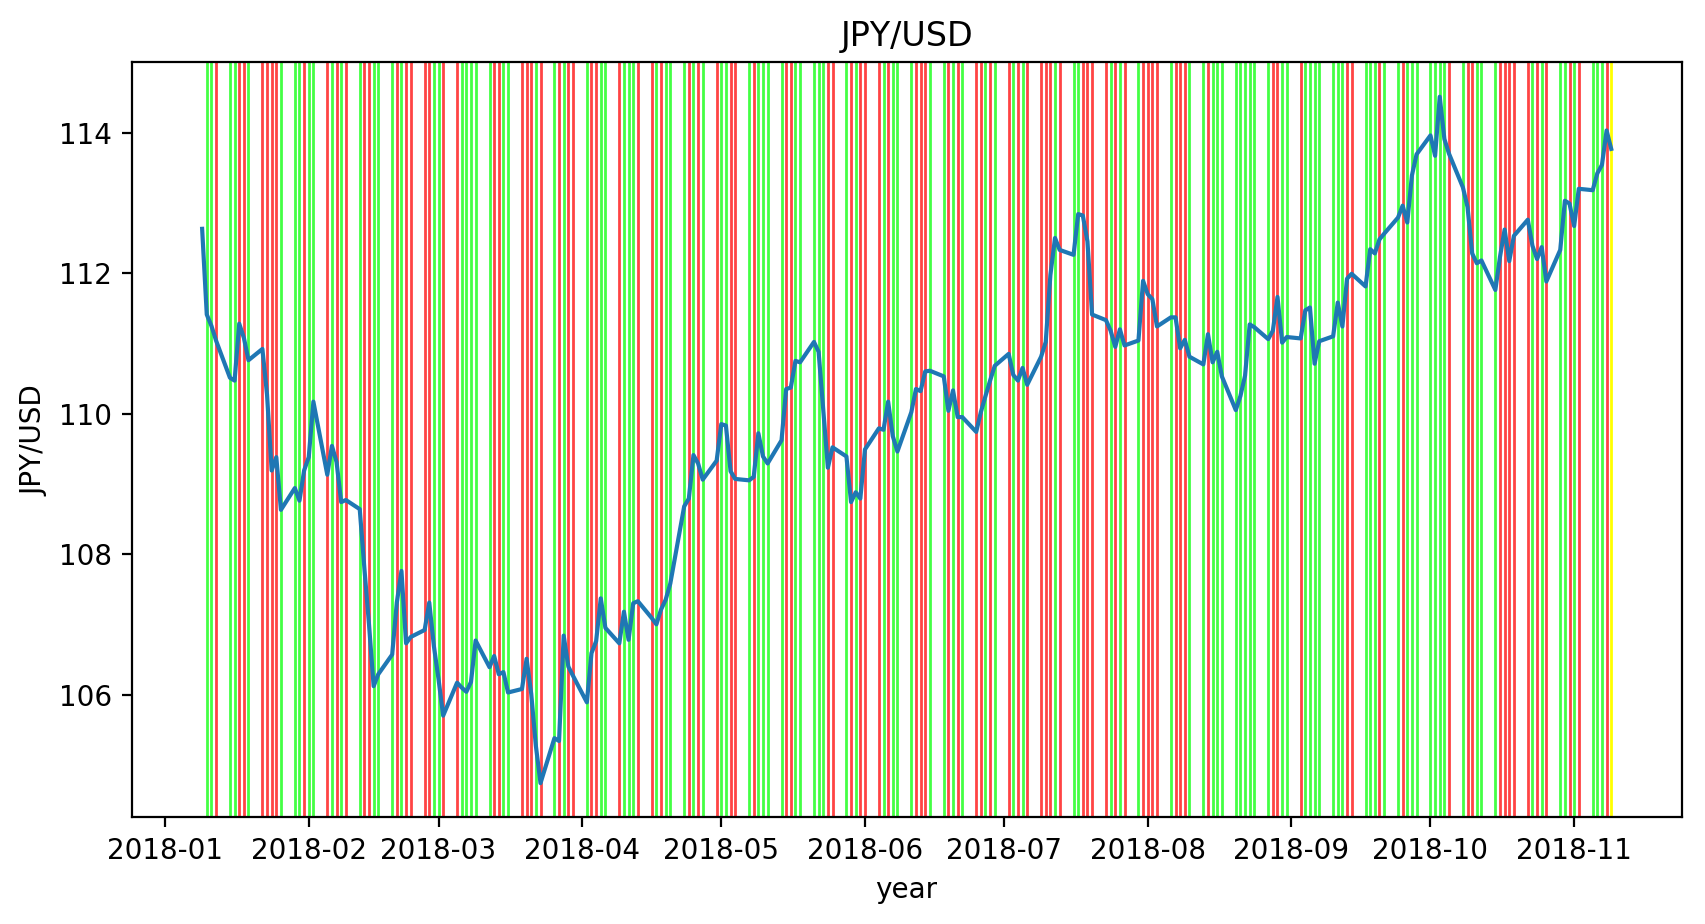

In [16]:
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col='Date', parse_dates=True)#読み込み
x = t_test.shape[0]
df = df[-1*x:]

result_color = []#予測が正しいかったか誤っていたかを記録
money = 100000#初期資産
money_transision = []#資金の変動を記録

for i in range(len(preds)):
        pred = np.argmax(preds[i,:])#argmaxとは配列の最大要素のインデックスを返すメソッドである
        tar = np.argmax(t_test[i,:])#★
        #matrix.iat[pred, tar] = matrix.iat[pred, tar] + 1
        
        coefficient = 1#係数（予測が正しければ１、誤っていれば－１）
        color = '#ff4444'
        if pred == tar :#完全一致
            #correct += 1
            color = '#44ff44'
        else :
            if pred+tar == 1 or pred+tar == 5 :
                #semi_correct += 1
                color = '#44ff44'
            else:
                coefficient = -1
        if i == len(preds)-1:
            color = '#ffff00'
              
        if i > 0:
            print(df.index[i])
            profit_and_loss = (df[i:i+1]['USD_JPY_Close'].values - df[i-1:i]['USD_JPY_Close'].values) * 10000
            print('profit and loss =',coefficient * abs(profit_and_loss[0]))
            money += coefficient * abs(profit_and_loss[0])
            print('money =', money, '\n')
            money_transision.append(money)
        
        result_color.append(color)

#fig5 = plt.figure()
plt.figure(figsize=(10,5),dpi=200)#グラフのサイズ変更
plt.title('JPY/USD')#タイトル
for i in range(len(df)):
    if i > 0:
        x = df[i:i+1].index[0]#インデックスの時刻のみ取り出す
        plt.axvspan(datetime.strptime(x.strftime('%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S'),
                    datetime.strptime(x.strftime('%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S'),
                    color=result_color[i])

plt.plot(df['USD_JPY_Close'])#ドル円の日足チャート
plt.xlabel('year')#x軸のラベル
plt.ylabel('JPY/USD')#y軸のラベル

print('money = \\', int(money))

## 予測結果（実験）

## 予測結果のグラフ（実験）

money = \ 158220


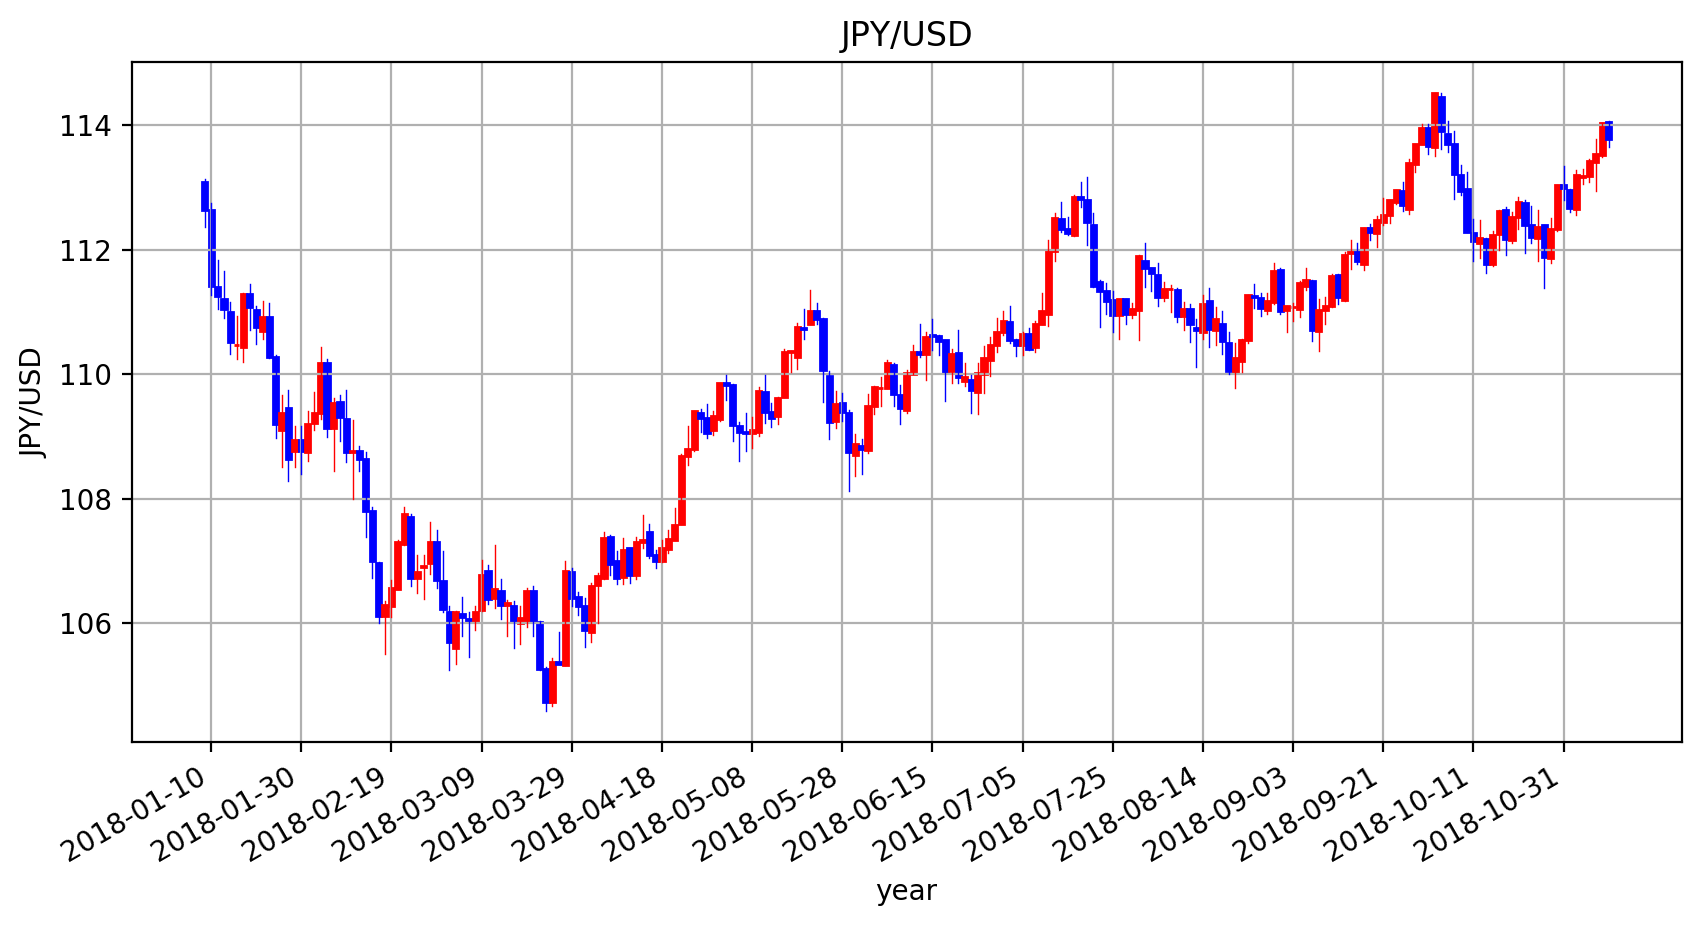

In [17]:
# グラフの作成---------------------------------------------------------------
fig = plt.figure(figsize=(10,5),dpi=200)#グラフのサイズ変更
ax = plt.subplot()

plt.title('JPY/USD')#タイトル
plt.xlabel('year')#x軸のラベル
plt.ylabel('JPY/USD')#y軸のラベル

#df = pd.read_csv('./csv_realtime/USD_JPY.csv', index_col='Date', parse_dates=True)
#df = df['2018':]

# numpy型行列を生成
ohlc = np.vstack((range(len(df)), df.values.T)).T # vstackは垂直結合、range関数によってdfの長さのリストが生成され、Tは転置行列を返す。

# ローソク足グラフの生成
mpf.candlestick_ohlc(ax, ohlc, width=0.8, colorup='r', colordown='b') # ローソク足の設定（widthは足の幅）

xtick0 = (5 - df_close.index[0].weekday())%5 # 最初の日を特定
period = 14 #メモリの間隔
# 第１引数が目盛りの指定、第２引数がラベルの指定●ここでエラー！
#plt.xticks(range(xtick0, len(df_close), period), [x.strftime('%Y-%m-%d') for x in df_close.index][xtick0::period])
plt.xticks(range(xtick0, len(df), period), [x.strftime('%Y-%m-%d') for x in df. index][xtick0::period])

ax.grid(True) # グリッドをつける
#ax.set_xlim(-1, len(df['USD_JPY_Close'])) # X軸での描画の上限を決める
fig.autofmt_xdate() # 日付の表示がいい感じになる

# ●ここでもエラー！
'''
for i in range(len(df['USD_JPY_Close'])):
    if i > 0:
        x = df[i:i+1].index[0]#インデックスの時刻のみ取り出す
        print(x)
        plt.axvspan(datetime.strptime(x.strftime('%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S'),
                    datetime.strptime(x.strftime('%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S'),
                    color=result_color[i])
'''

#ax.plot(df['USD_JPY_Close'])#ドル円の日足チャート

print('money = \\', int(money))

# 学習の経過のグラフの表示

Text(0, 0.5, 'categorical_accuracy')

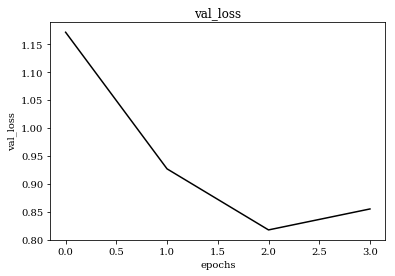

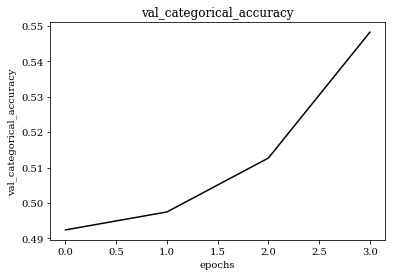

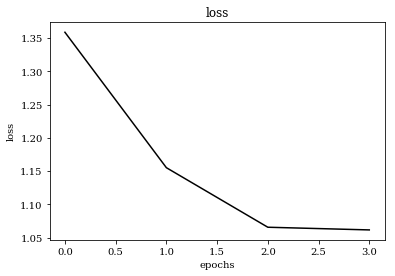

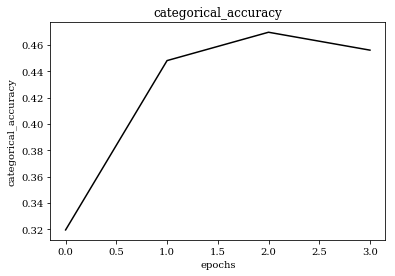

In [18]:
# 学習の進み具合を可視化
val_loss = prediction.hist.history['val_loss']
val_categorical_accuracy = prediction.hist.history['val_categorical_accuracy']
loss = prediction.hist.history['loss']
categorical_accuracy = prediction.hist.history['categorical_accuracy']

#
plt.rc('font', family='serif')

#
fig1 = plt.figure()
plt.title('val_loss')
plt.plot(prediction.hist.epoch, val_loss, label='acc', color='black')
plt.xlabel('epochs')
plt.ylabel('val_loss')

#
fig2 = plt.figure()
plt.title('val_categorical_accuracy')
plt.plot(prediction.hist.epoch, val_categorical_accuracy, label='acc', color='black')
plt.xlabel('epochs')
plt.ylabel('val_categorical_accuracy')

#
fig3 = plt.figure()
plt.title('loss')
plt.plot(prediction.hist.epoch, loss, label='acc', color='black')
plt.xlabel('epochs')
plt.ylabel('loss')

#
fig4 = plt.figure()
plt.title('categorical_accuracy')
plt.plot(prediction.hist.epoch, categorical_accuracy, label='acc', color='black')
plt.xlabel('epochs')
plt.ylabel('categorical_accuracy')

## その他

In [19]:
#日経平均の始値と終値の差
'''
df = pd.read_csv(csv_path+'nikkei.csv', index_col='Date', parse_dates=True)#読み込み
df = df.apply(np.log)*100#正規化
df = df['nikkei_Close'] - df['nikkei_Open']#終値と始値の差を求める
df = df['1988-04-08':]#始値と終値と高値と安値が記録され始めた日からのみ抽出
#df = df.diff(x_days_later)#特定の日数後の増減を求める
#df = df.drop(df.index[0:x_days_later], axis=0)#特定の日数分の行を削除
#df = df_shift(df, x_days_later)
df = df.rename('nikkei_diff')#名前を付ける
df_list.append(df)
'''



# 日経平均の移動平均を追加する実験
'''
df = pd.read_csv(csv_path+'nikkei.csv', index_col='Date', parse_dates=True)
df_list.append(GCDC(df['nikkei_Close'], 5, 25))
df = pd.read_csv(csv_path+'nikkei.csv', index_col='Date', parse_dates=True)
df_list.append(GCDC(df['nikkei_Close'], 25, 75))

# ドル円の移動平均を追加する実験
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col='Date', parse_dates=True)
df_list.append(GCDC(df['USD_JPY_Close'], 5, 25))
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col='Date', parse_dates=True)
df_list.append(GCDC(df['USD_JPY_Close'], 25, 75))
    
df_list.append(add_data(csv_path+'TOPIX.csv'))
df_list.append(add_data(csv_path+'BTC_USD.csv'))
df_list.append(add_data(csv_path+'GSPC.csv'))
df_list.append(add_data(csv_path+'RUT.csv'))
df_list.append(add_data(csv_path+'TNX.csv'))
'''


"\ndf = pd.read_csv(csv_path+'nikkei.csv', index_col='Date', parse_dates=True)\ndf_list.append(GCDC(df['nikkei_Close'], 5, 25))\ndf = pd.read_csv(csv_path+'nikkei.csv', index_col='Date', parse_dates=True)\ndf_list.append(GCDC(df['nikkei_Close'], 25, 75))\n\n# ドル円の移動平均を追加する実験\ndf = pd.read_csv(csv_path+'USD_JPY.csv', index_col='Date', parse_dates=True)\ndf_list.append(GCDC(df['USD_JPY_Close'], 5, 25))\ndf = pd.read_csv(csv_path+'USD_JPY.csv', index_col='Date', parse_dates=True)\ndf_list.append(GCDC(df['USD_JPY_Close'], 25, 75))\n    \ndf_list.append(add_data(csv_path+'TOPIX.csv'))\ndf_list.append(add_data(csv_path+'BTC_USD.csv'))\ndf_list.append(add_data(csv_path+'GSPC.csv'))\ndf_list.append(add_data(csv_path+'RUT.csv'))\ndf_list.append(add_data(csv_path+'TNX.csv'))\n"

In [15]:
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col='Date', parse_dates=True)#読み込み
x = t_test.shape[0]
df = df[-1*x:]

result_color = []#予測が正しいかったか誤っていたかを記録
money = 100000#初期資産
money_transision = []#資金の変動を記録

for i in range(len(preds)):
        pred = np.argmax(preds[i,:])#argmaxとは配列の最大要素のインデックスを返すメソッドである
        tar = np.argmax(t_test[i,:])#★
        #matrix.iat[pred, tar] = matrix.iat[pred, tar] + 1
        
        coefficient = 1#係数（予測が正しければ１、誤っていれば－１）
        color = '#ff4444'
        if pred == tar :#完全一致
            color = '#44ff44'
        else :
            if pred+tar == 1 or pred+tar == 5 :
                color = '#44ff44'
            else:
                coefficient = -1
        if i == len(preds)-1:
            color = '#ffff00'
              
        if i > 0:
            print(df.index[i])
            profit_and_loss = (df[i:i+1]['USD_JPY_Close'].values - df[i-1:i]['USD_JPY_Close'].values) * 10000
            print('profit and loss =',coefficient * abs(profit_and_loss[0]))
            money += coefficient * abs(profit_and_loss[0])
            print('money =', money, '\n')
            money_transision.append(money)
        
        result_color.append(color)

2018-02-21 00:00:00
profit and loss = -4500.000000000028
money = 95499.99999999997 

2018-02-22 00:00:00
profit and loss = 10300.000000000011
money = 105799.99999999999 

2018-02-23 00:00:00
profit and loss = -899.999999999892
money = 104900.00000000009 

2018-02-26 00:00:00
profit and loss = 1000.0000000000853
money = 105900.00000000017 

2018-02-27 00:00:00
profit and loss = 3900.0000000000055
money = 109800.00000000017 

2018-02-28 00:00:00
profit and loss = 6200.0000000000455
money = 116000.00000000022 

2018-03-01 00:00:00
profit and loss = 4699.999999999989
money = 120700.0000000002 

2018-03-02 00:00:00
profit and loss = -5199.99999999996
money = 115500.00000000025 

2018-03-05 00:00:00
profit and loss = -4699.999999999989
money = 110800.00000000026 

2018-03-06 00:00:00
profit and loss = 700.0000000000739
money = 111500.00000000033 

2018-03-07 00:00:00
profit and loss = -599.9999999998806
money = 110900.00000000045 

2018-03-08 00:00:00
profit and loss = -1400.0000000000057
mo